# Tendencias & Clustering de usuarios de Instagram #Madrid


#### Álvaro Cerrato

<img src="https://stonebond.com/wp-content/uploads/2017/03/Big-Data-funnel.png" style= "wi" >

## 00. Introducción al análisis

El objetivo inicial del proyecto es:

1) Analizar las tendencias en Redes Sociales (Instagram) para los hashtags designados

2) Intereses a nivel de usuario para una comunicación personalizada

3) Comparativa entre los hashtags elegidos

4) Clustering según comportamiento de los usuarios

Cada foto ingestada en el proceso de Web scraping en el momento de capturar la imagen, también captura el id del usuario, el momento en el que fue subida a Instagram y el número de liks, esto era almacenado en el nombre de la imagen.

El procesamiento es llevado a cabo por el modelo Image AI, con unos pesos pre-entrenados, pues el objetivo del proyecto no es entrenar a un modelo, si no explotar la data contenido en la Red Social. 
Este modelo con los pesos está ideado para reconocer una amplia variedad de objetos, NO PERSONAS, ya que esto nos daría poco valor, pues en una red social,hay muchas fotos de personas, lo interesante es extraer en que contexto estarían estas personas.

Nota: Por cada foto procesada se obtiene una única predicción, (la más probable) junto con la confianza que da el modelo de acertar con la predicción.


## 01. Descripción de las variables del dataset

De esta manera, el dataset queda distribuido con los datos de:

    - ID: (Int)id único de usuario en Instagram, en la red social, el nick puede cambiarse, pero no este id

    - postTime: (Time YYYYmmdd-HHMMSS) Momento en el que el post es subido a Instagram

    - nLike: (Int) Número de liks en el momento que la es capturada, hay que teneren cuenta que estamos analizando fotos recientes, capturando una muestra de las últimas fotos cada 10 minutos, por lo que el número de liks no son elevados. Aunque si podremos deducir que una foto con "alto" número de liks (dado este contexto) es de usuarios con más o menos seguidores o fotos más o menos relevantes para sus seguidores 

    - predicción: (Text) Salida que devuelve el modelo tras el procesamiento de la imagen

    - probability: (Double) Confianza del modelo, para acertar con la predicción.

## 02. Carga de datos y librería 



In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D


#Nos descargamos las predicciones a local
# Importamos el dataset de predicciones de Madrid y printamos las 10 primeras columnas

df_MAD = pd.read_csv("../04_procesamiento/local/results.csv", sep=',')

df_MAD['hashtag']='MADRID'

df_MAD.head()

,ID,postTime,nLike,prediction,probability,hashtag
0,1.518881e+10,20191109-204253,17,web_site,62.115800,MADRID
1,2.834276e+08,20191110-211900,14,water_jug,15.866615,MADRID
2,4.092103e+09,20191110-151330,2,jersey,37.186092,MADRID
3,9.984124e+09,20191109-004346,9,abaya,14.688089,MADRID
4,2.189192e+09,20191109-185521,1,lipstick,55.786526,MADRID


In [2]:
#Cargamos el dataset de predicciones de Strabucks y printamos las 10 primeras columnas

df_STB = pd.read_csv("../04_procesamiento/local/results_STB.csv", sep=',')

df_STB['hashtag']='STARBUCKS'

df_STB.head()

,ID,postTime,nLike,prediction,probability,hashtag
0,24973709443,20191119-001755,3,chain,31.034738,STARBUCKS
1,207822948,20191119-001746,4,water_bottle,19.389835,STARBUCKS
2,4151202487,20191119-001741,1,saltshaker,17.497170,STARBUCKS
3,3655729292,20191119-001650,1,shower_cap,99.968469,STARBUCKS
4,1776841672,20191119-001602,3,swimming_trunks,35.442916,STARBUCKS


In [3]:
#Concatenamos ambos datasets para tener uno único pero distinguiendo por el hashtag

df = pd.concat([df_MAD, df_STB])

df.head()

,ID,postTime,nLike,prediction,probability,hashtag
0,1.518881e+10,20191109-204253,17,web_site,62.115800,MADRID
1,2.834276e+08,20191110-211900,14,water_jug,15.866615,MADRID
2,4.092103e+09,20191110-151330,2,jersey,37.186092,MADRID
3,9.984124e+09,20191109-004346,9,abaya,14.688089,MADRID
4,2.189192e+09,20191109-185521,1,lipstick,55.786526,MADRID


## 03. Exploración y transformación de las variables 



In [4]:
## Dividimos la variable postTime, para contar con el día y la hora por separado
new = df["postTime"].str.split("-", n = 1, expand = True) 

#Cambiamos el tipo de variable de Id para que sea object y no un entero
df["ID"] = df["ID"].astype(object)

#Nuevo dataframe con las variables divididas y su posición
df["day"]= new[0] 
df["hour"]= new[1] 

df['h'] = df['hour'].str[:2]
df['m'] = df['hour'].str[2:4]

### Tipología de los datos


In [5]:
df.dtypes

ID              object
postTime        object
nLike            int64
prediction      object
probability    float64
hashtag         object
day             object
hour            object
h               object
m               object
dtype: object

### Variables numéricas

In [6]:
df.describe()

,nLike,probability
count,31917.00000,31917.000000
mean,38.96682,44.914646
std,225.18975,26.249597
min,1.00000,2.723868
25%,1.00000,23.151661
50%,3.00000,39.376184
75%,8.00000,64.080942
max,12397.00000,100.000000


### nLike

Text(0.5, 0.98, 'Top likes por foto')

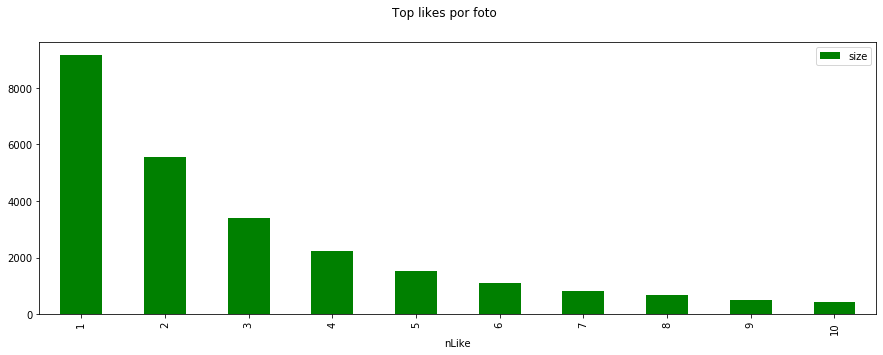

In [7]:
df.groupby('nLike').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10).plot(x = 'nLike', kind = 'bar', color='green', figsize=(15,5))

pl.suptitle("Top likes por foto")

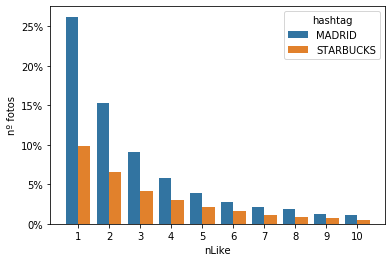

In [8]:
nLike = df[df.nLike <= 10]

def dob_histogram_gender(feature, orient='v', axis_name="nº fotos"):
    ratios = pd.DataFrame()
    his = nLike.groupby(feature)["hashtag"].value_counts().to_frame()
    his = his.rename({"hashtag": axis_name}, axis=1).reset_index()
    his[axis_name] = his[axis_name]/len(nLike)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='hashtag', data=his, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='hashtag', data=his, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
dob_histogram_gender("nLike")


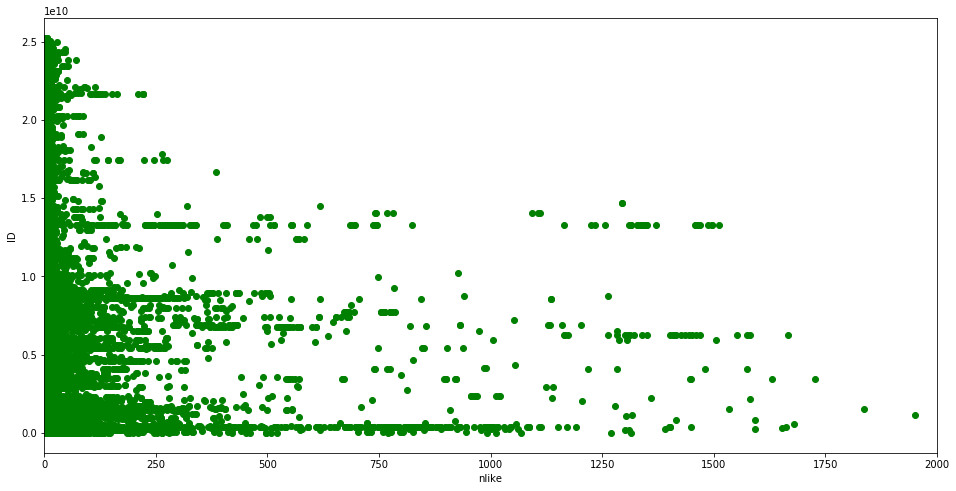

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['nLike'], df['ID'], color='green')
ax.set_xlim([0,2000])
ax.set_xlabel('nlike')
ax.set_ylabel('ID')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


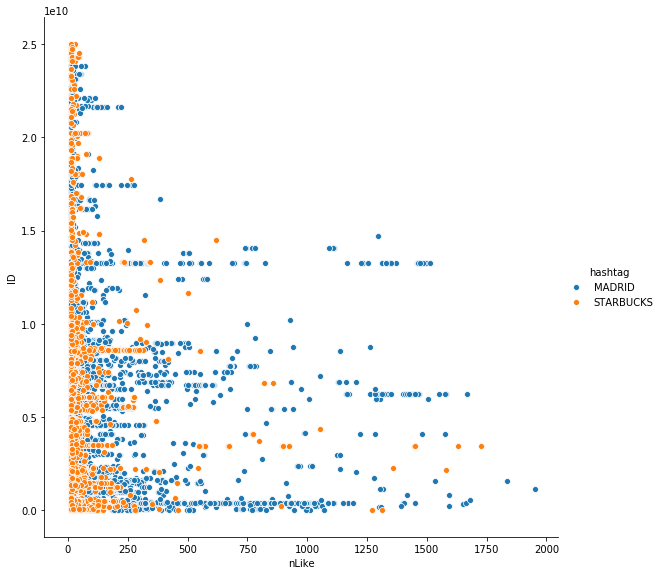

In [10]:
nLike = df[(df.nLike >10) & (df.nLike < 2000)]

sns.pairplot(x_vars=['nLike'], y_vars=['ID'], data=nLike, hue="hashtag", size=8)

### Probability

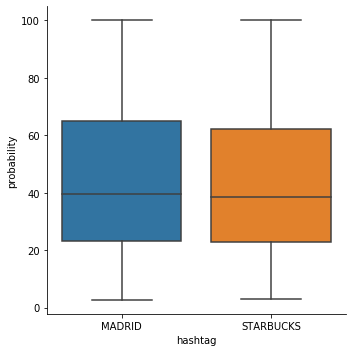

In [11]:
ax = sns.catplot(y="probability", x="hashtag", kind="box", data=df)

### ID

Text(0.5, 0.98, 'Top fotos por usuario')

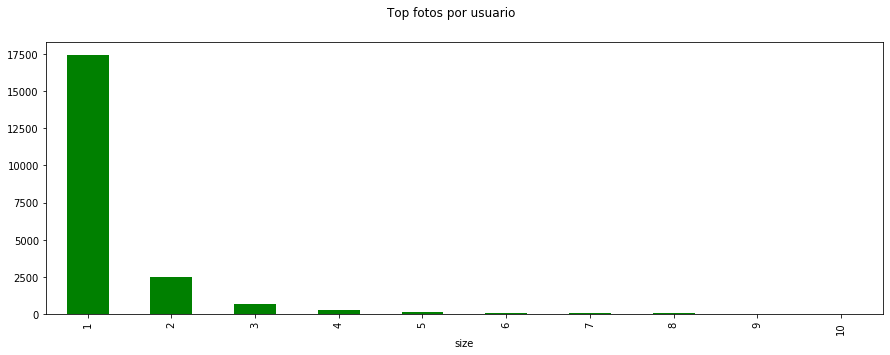

In [12]:
fotos_usuario = df.groupby('ID').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

fotos_usuario.groupby('size').size().head(10).plot(kind = 'bar',color='green', figsize=(15,5))

pl.suptitle("Top fotos por usuario")


### Day

Text(0.5, 0.98, 'Distribución de imagenes por día')

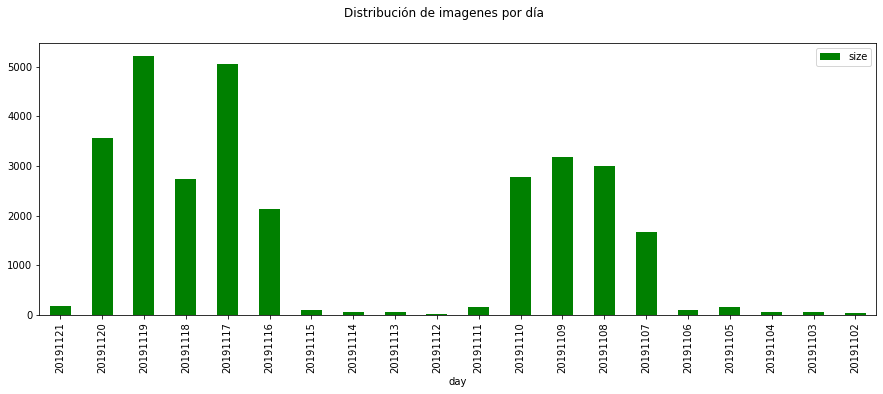

In [13]:
#La muestra no fue recogida de forma constante

df.groupby('day').size().to_frame('size').reset_index().sort_values(['day'], ascending=[False]).head(20).plot(x = 'day', kind = 'bar',color='green', figsize=(15,5))

pl.suptitle("Distribución de imagenes por día")

## Hour

Text(0.5, 0.98, 'Distribución de imagenes por hora')

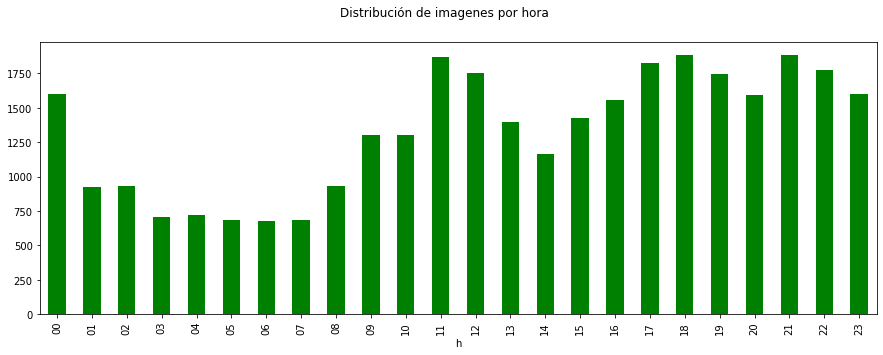

In [14]:
df.groupby('h').size().plot(kind = 'bar',color='green', figsize=(15,5))

pl.suptitle("Distribución de imagenes por hora")

### Minute

Text(0.5, 0.98, 'Distribución de imagenes por minuto')

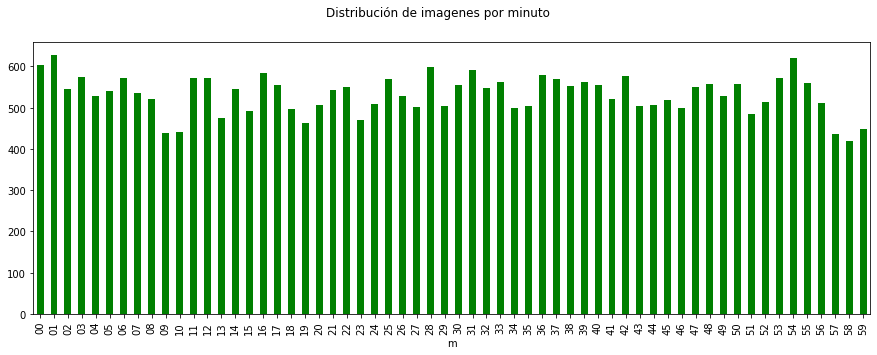

In [15]:
df.groupby('m').size().plot(kind = 'bar', color='green', figsize=(15,5))

pl.suptitle("Distribución de imagenes por minuto")

## 04. Exploración de "Predictions"

Text(0.5, 0.98, 'Top likes por foto')

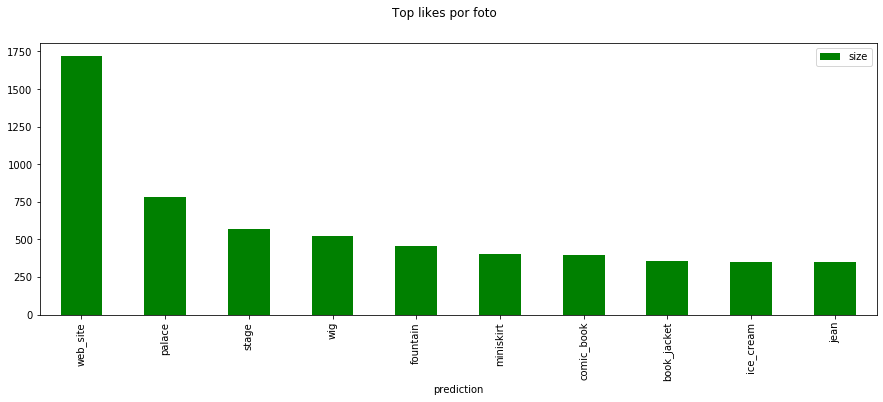

In [16]:
#Top 10 de predicciones más frecuentes
df.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10).plot(x = 'prediction', kind = 'bar',color='green', figsize=(15,5))

pl.suptitle("Top likes por foto")

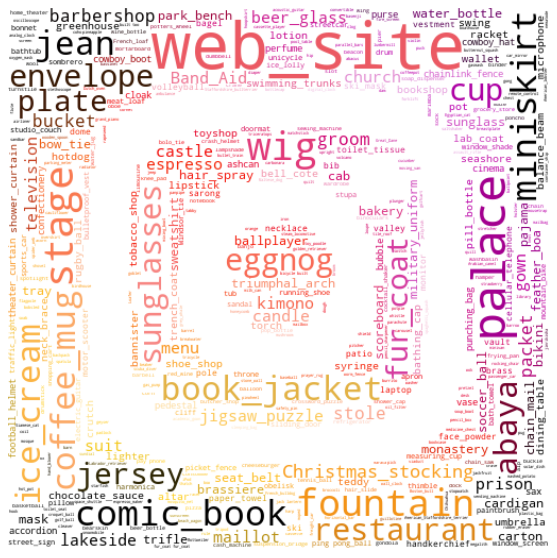

In [17]:
# Transformamos las predicciones para después poder ser contenidas en la nube de palabras en función de su peso

pred = df["prediction"].tolist()

pred = str(pred)

pred = pred.replace("'","")

mask = np.array(Image.open("./IG.png"))
wordcloud_ig = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(pred)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_ig.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### Confianza >= 90

Text(0.5, 0.98, 'Top likes por foto')

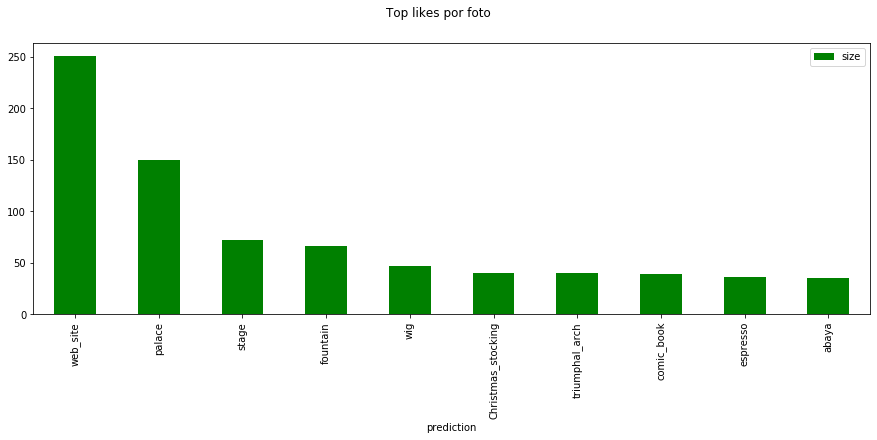

In [18]:
#Tomamos solo las predicciones >= 90 de confianza
df_90 = df[df.probability >= 90]
df_90.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10).plot(x = 'prediction', kind = 'bar',color='green', figsize=(15,5))

pl.suptitle("Top likes por foto")

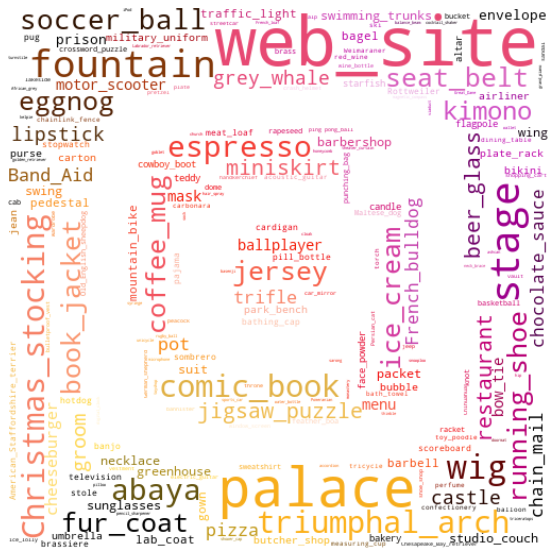

In [19]:
# Transformamos las predicciones para después poder ser contenidas en la nube de palabras en función de su peso
pred_90 = df_90["prediction"].tolist()

pred_90 = str(pred_90)

pred_90 = pred_90.replace("'","")

mask = np.array(Image.open("./IG.png"))
wordcloud_ig = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(pred_90)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_ig.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("./IG_WordCloud.png", format="png")

plt.show()

### MADRID

Text(0.5, 0.98, 'Top predictions')

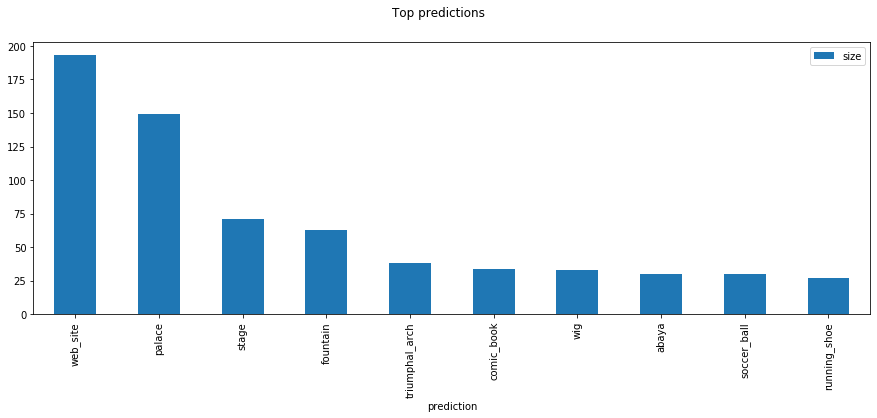

In [20]:
#Top predicciones para MADRID

df_90_MAD = df[(df.probability >= 90) & (df.hashtag == 'MADRID')]

df_90_MAD.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10).plot(x = 'prediction', kind = 'bar', figsize=(15,5))

pl.suptitle("Top predictions")

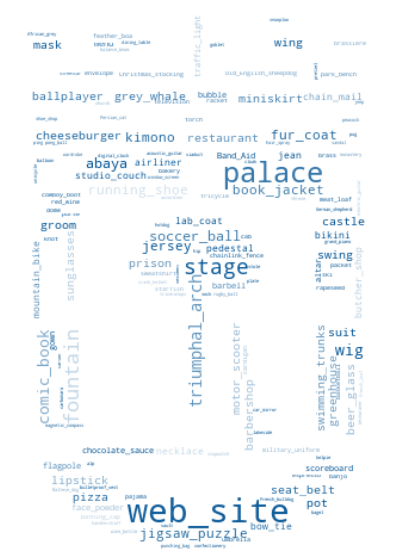

In [21]:
# Transformamos las predicciones para después poder ser contenidas en la nube de palabras en función de su peso

pred_90_MAD = df_90_MAD["prediction"].tolist()

pred_90_MAD = str(pred_90_MAD)

pred_90_MAD = pred_90_MAD.replace("'","")

mask = np.array(Image.open("./MADRID3.png"))
wordcloud_ig = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(pred_90_MAD)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_ig.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("./MAD.png", format="png")

plt.show()

Text(0.5, 0.98, 'Top predictions')

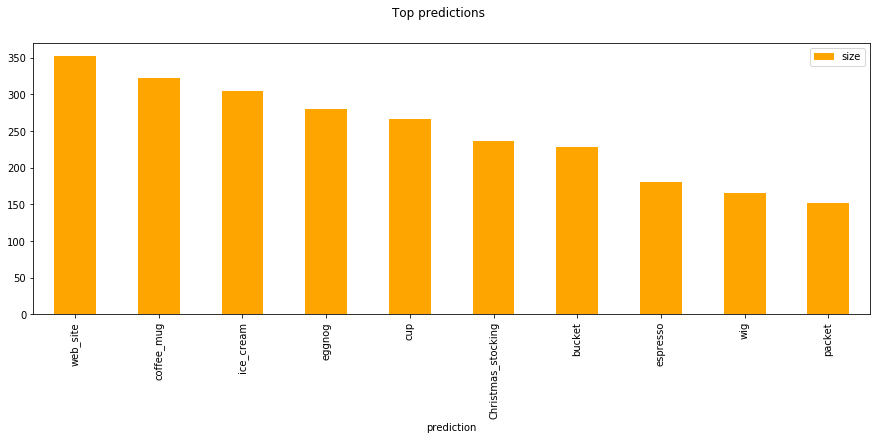

In [22]:
#Top predicciones para STARBUCKS

df_90_STB = df[(df.hashtag == 'STARBUCKS')]

df_90_STB.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10).plot(x = 'prediction', color='orange', kind = 'bar', figsize=(15,5))

pl.suptitle("Top predictions")

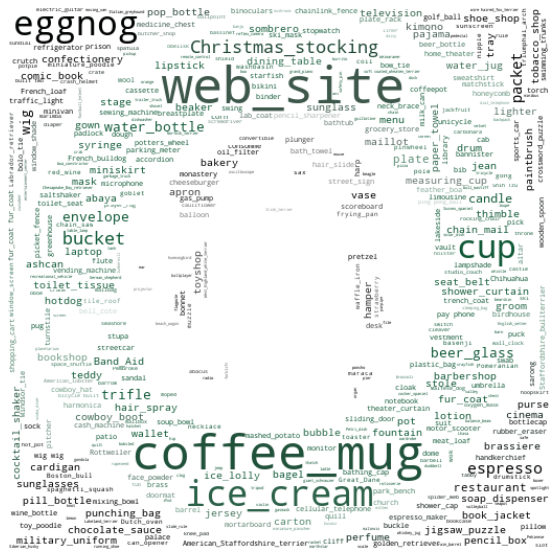

In [23]:
# Transformamos las predicciones para después poder ser contenidas en la nube de palabras en función de su peso
pred_90_STB = df_90_STB["prediction"].tolist()

pred_90_STB = str(pred_90_STB)

pred_90_STB = pred_90_STB.replace("'","")

mask = np.array(Image.open("./STARBUCKS.png"))
wordcloud_ig = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(pred_90_STB)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_ig.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("./STB.png", format="png")

plt.show()

## 05. Tendencias por día

Text(0.5, 0.98, 'Tendencias por día MADRID')

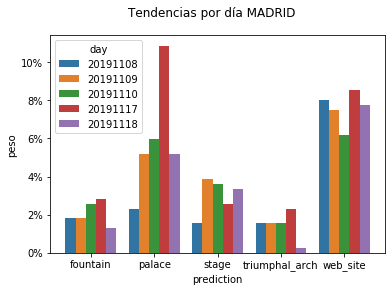

In [24]:
#Para visualizarlo de manera más simplificada tomamos unicamente las predicciones más frecuentes y los días con mayor muestra

df_90_topDays_MAD = df_90_MAD.groupby('day').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(5)
df_90_topPred_MAD = df_90_MAD.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(5)

day_MAD = df_90_topDays_MAD.day.tolist()
predictions_MAD = df_90_topPred_MAD.prediction.tolist()

df_day_MAD = df_90_MAD[(df_90_MAD.day.isin(day_MAD))&(df_90_MAD.prediction.isin(predictions_MAD))]

def dob_histogram_predictions(feature, orient='v', axis_name="peso"):
    ratios = pd.DataFrame()
    his = df_day_MAD.groupby(feature)["day"].value_counts().to_frame()
    his = his.rename({"day": axis_name}, axis=1).reset_index()
    his[axis_name] = his[axis_name]/len(df_day_MAD)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='day', data=his, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='day', data=his, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
dob_histogram_predictions("prediction")

pl.suptitle("Tendencias por día MADRID")

In [25]:
# tabla de contingencia en porcentajes relativos segun dia
tendencias_relativas_totales_MAD =pd.crosstab(index=df_day_MAD['day'], columns=df_day_MAD['prediction']).apply(lambda r: r/r.sum() *100, axis=1)

tendencias_relativas_totales_MAD

prediction,fountain,palace,stage,triumphal_arch,web_site
day,,,,,
20191108,11.864407,15.254237,10.169492,10.169492,52.542373
20191109,9.090909,25.974026,19.480519,7.792208,37.662338
20191110,12.987013,29.870130,18.181818,7.792208,31.168831
20191117,10.476190,40.000000,9.523810,8.571429,31.428571
20191118,7.246377,28.985507,18.840580,1.449275,43.478261


Text(0.5, 0.98, 'Tendencias por día MADRID')

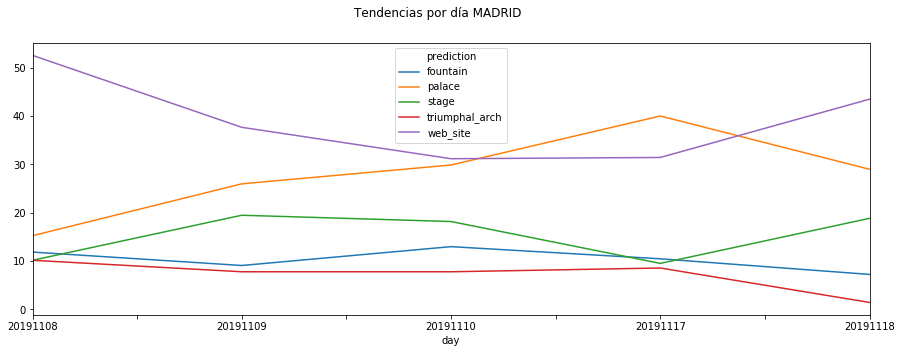

In [26]:
tendencias_relativas_totales_MAD =pd.crosstab(index=df_day_MAD['day'], columns=df_day_MAD['prediction']).apply(lambda r: r/r.sum() *100, axis=1)

tendencias_relativas_totales_MAD.plot(kind = 'line', figsize=(15,5))

pl.suptitle("Tendencias por día MADRID")

Text(0.5, 0.98, 'Tendencias por día STARBUCKS')

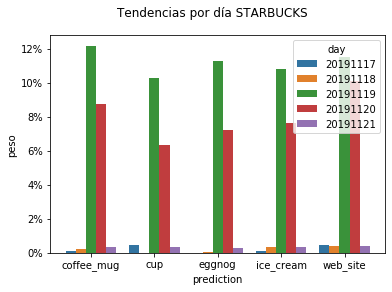

In [27]:
#Para visualizarlo de manera más simplificada tomamos unicamente las predicciones más frecuentes y los días con mayor muestra

df_90_topDays_STB = df_90_STB.groupby('day').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(5)
df_90_topPred_STB = df_90_STB.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(5)

day_STB = df_90_topDays_STB.day.tolist()
predictions_STB = df_90_topPred_STB.prediction.tolist()

df_day_STB = df_90_STB[(df_90_STB.day.isin(day_STB))&(df_90_STB.prediction.isin(predictions_STB))]

def dob_histogram_predictions(feature, orient='v', axis_name="peso"):
    ratios = pd.DataFrame()
    his = df_day_STB.groupby(feature)["day"].value_counts().to_frame()
    his = his.rename({"day": axis_name}, axis=1).reset_index()
    his[axis_name] = his[axis_name]/len(df_day_STB)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='day', data=his, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='day', data=his, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
dob_histogram_predictions("prediction")

pl.suptitle("Tendencias por día STARBUCKS")

In [28]:
# tabla de contingencia en porcentajes relativos segun dia
tendencias_relativas_totales_STB =pd.crosstab(index=df_day_STB['day'], columns=df_day_STB['prediction']).apply(lambda r: r/r.sum() *100, axis=1)

tendencias_relativas_totales_STB

prediction,coffee_mug,cup,eggnog,ice_cream,web_site
day,,,,,
20191117,11.111111,38.888889,0.000000,11.111111,38.888889
20191118,20.000000,0.000000,6.666667,33.333333,40.000000
20191119,21.733822,18.315018,20.146520,19.291819,20.512821
20191120,21.805792,15.843271,18.057922,19.080068,25.212947
20191121,20.000000,20.000000,16.000000,20.000000,24.000000


Text(0.5, 0.98, 'Tendencias por día STARBUCKS')

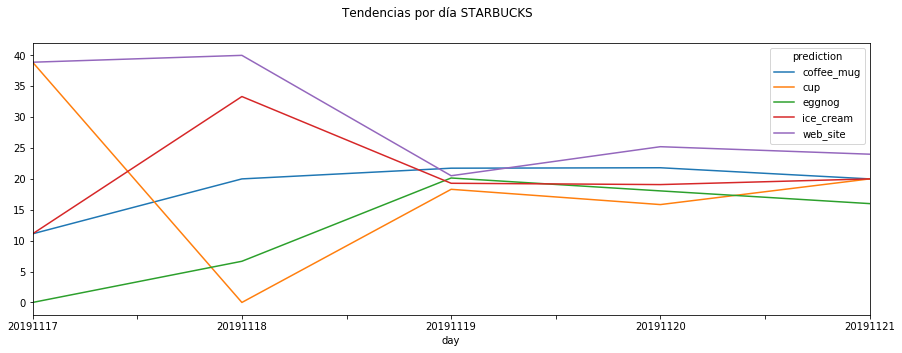

In [29]:
tendencias_relativas_totales_STB =pd.crosstab(index=df_day_STB['day'], columns=df_day_STB['prediction']).apply(lambda r: r/r.sum() *100, axis=1)

tendencias_relativas_totales_STB.plot(kind = 'line', figsize=(15,5))

pl.suptitle("Tendencias por día STARBUCKS")

## 06. Segmentación de usuarios 

In [30]:
# Del dataset donde filtrabamos por las predicciones de MADRID con confianza igual o superior a 90, tomaremos las predicciones más frecuentes 
df_90_topPred_MAD = df_90_MAD.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10)
predictions_MAD = df_90_topPred_MAD.prediction.tolist()

segment_MAD = df_day_MAD = df_90_MAD[(df_90_MAD.prediction.isin(predictions_MAD))][['ID', 'hashtag', 'prediction']]
segment_MAD.to_csv(r'./segment/MAD.csv')


In [31]:
# Del dataset donde filtrabamos por las predicciones de STARBUCKS con confianza igual o superior a 90, tomaremos las predicciones más frecuentes 
df_90_topPred_STB = df_90_STB.groupby('prediction').size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).head(10)
predictions_STB = df_90_topPred_STB.prediction.tolist()

segment_STB = df_90_STB[(df_90_STB.prediction.isin(predictions_STB))][['ID', 'hashtag', 'prediction']]
segment_STB.to_csv(r'./segment/STB.csv')


## 07. Comparativa entre hashtags

Text(0.5, 0.98, 'TOP Tendencias MADRID')

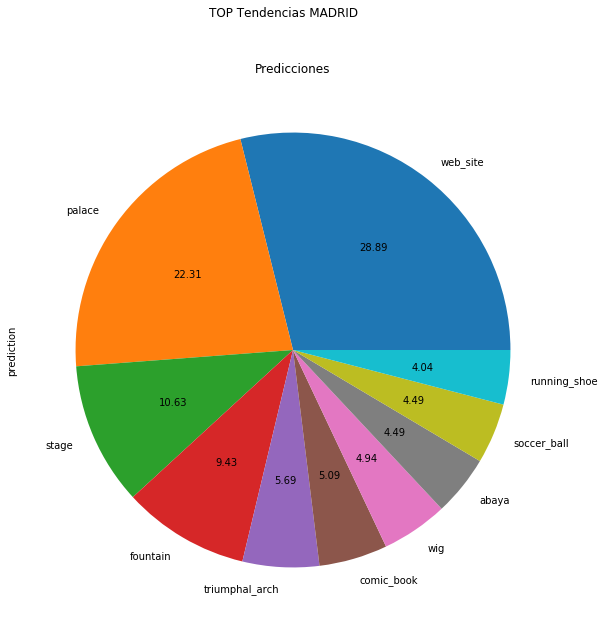

In [32]:
#Top predictions MADRID

plot = df_day_MAD['prediction'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(10, 10), title='Predicciones')

pl.suptitle("TOP Tendencias MADRID")

Text(0.5, 0.98, 'TOP Tendencias STARBUCKS')

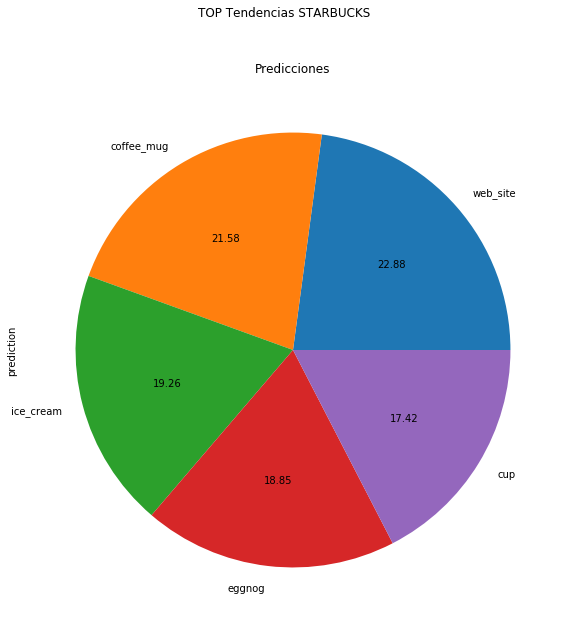

In [33]:
#Top predictions STARBUCKS

plot = df_day_STB['prediction'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(10, 10), title='Predicciones')

pl.suptitle("TOP Tendencias STARBUCKS")

## 08. Clustering

En este punto de la analítica se van a formar clusters con los usuarios. 

El problema es que nuestra variable diferencial (predictions) es categórica y las predicciones son bastante especificas, por lo que un método como One hot encoding no tiene sentido, pues formaría clusters de usuarios para cada posible valor de la predicción, siendo muy diverso.

Posibles soluciones (aunque no implementadas) sería tener por detras un modelo del lenguaje capaz de entender la relacción y distancia entre las palabras y como unas son más afines entre sí que otras.
Además deberíamos tener mayor número de variables.

Ante estos impedimentos se tratará de formar clusters con las variables que parecen tener sentido para ello, como podría ser n_Like, hora y el día de la semana

In [34]:
df['day'] = pd.to_datetime(df['day'])

df['weekday'] = df['day'].dt.dayofweek

In [35]:
df_cluster = df[['nLike', 'h', 'weekday']]

df_cluster["h"] = df["h"].astype(int)

X = df_cluster

/home/cerrato/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


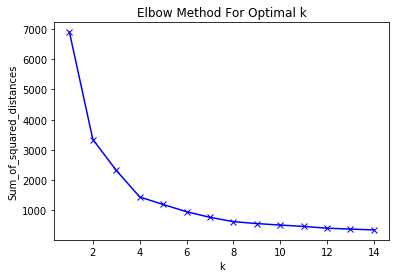

In [36]:
mms = MinMaxScaler()
mms.fit(X)
data_transformed = mms.transform(X)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [37]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[1.42681790e+01 1.31238713e+01 3.45686193e+00]
 [4.35500000e+03 1.05306122e+01 4.22448980e+00]
 [1.51304930e+03 1.45352113e+01 2.59859155e+00]
 [6.13910744e+02 1.45586777e+01 3.12396694e+00]]


In [38]:

labels = kmeans.predict(X)
# Obtenemos el centro de los clusters
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan']
asignar=[]
for row in labels:
    asignar.append(colores[row])


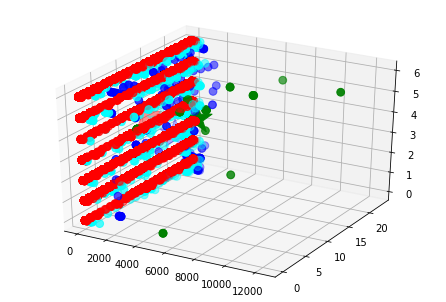

In [39]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X.iloc[:, 0],X.iloc[:, 1], X.iloc[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

Como se comentó al principio de este ejercicio, realizar un cluster con las variables presentes no tiene mucho sentido, además, las fotos suelen ser capturadas al poco de ser posteadas, por lo que el número de likes es muy inferior y tampoco se puede tratar de agrupar usuarios por el comportamiento en redes.